# Calcul des coefficients des 5 fonctions de transferts

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import signal as sg
from scipy import integrate
from scipy.interpolate import interpn,interp1d,RegularGridInterpolator, Akima1DInterpolator

import time
from tqdm import notebook
import importlib

import torch
from torch.utils.data import TensorDataset, DataLoader

import tarfile

%matplotlib inline

import copy

J'ai un modifié pred pour qu'elle puisse fonctionner pour n'importe quel degré de fonction de transfert

In [21]:
from scipy.optimize import minimize
import scipy.signal as sig
from scipy.optimize import least_squares

#b = [2,1]       # numerateur
#a = [1,0.5,1]     # denominateur

#H_1 = sig.lti(b,a)

def pred(x, t_e, entree):
    b = x[:int(len(x)/2)]
    a = x[int(len(x)/2):]
    H_1 = sig.lti(b,a)
    [t_s, sortie, xout] = H_1.output(entree,t_e)
    return sortie

def err(x, t, entree, y):
    return (pred(x, t, entree) - y)**2

def err_multi(x, times, entrees, outputs):
    error = 0
    for k in range(len(entrees)) :
        error += np.mean(err(x,times[k],entrees[k],outputs[k]))
    return error 

def RMSE(real,prediction):
    rmse = 0
    for k in range(len(real)):
        rmse += (real[k]-prediction[k])**2
    return rmse/len(real)

In [3]:
rep_data = "./data/DataSet_phase1/"
names = ["input"+str(k) for k in range(0,7)]  

d = {}
for name in names:
    d[name] = pd.read_csv(rep_data + name + '.csv',sep=',',index_col=False)
    
columns_titles = ['Time','Input','Output1','Output2','Output3','Output4','Output5']

for name in names:
    d[name] = d[name].reindex(columns = columns_titles)

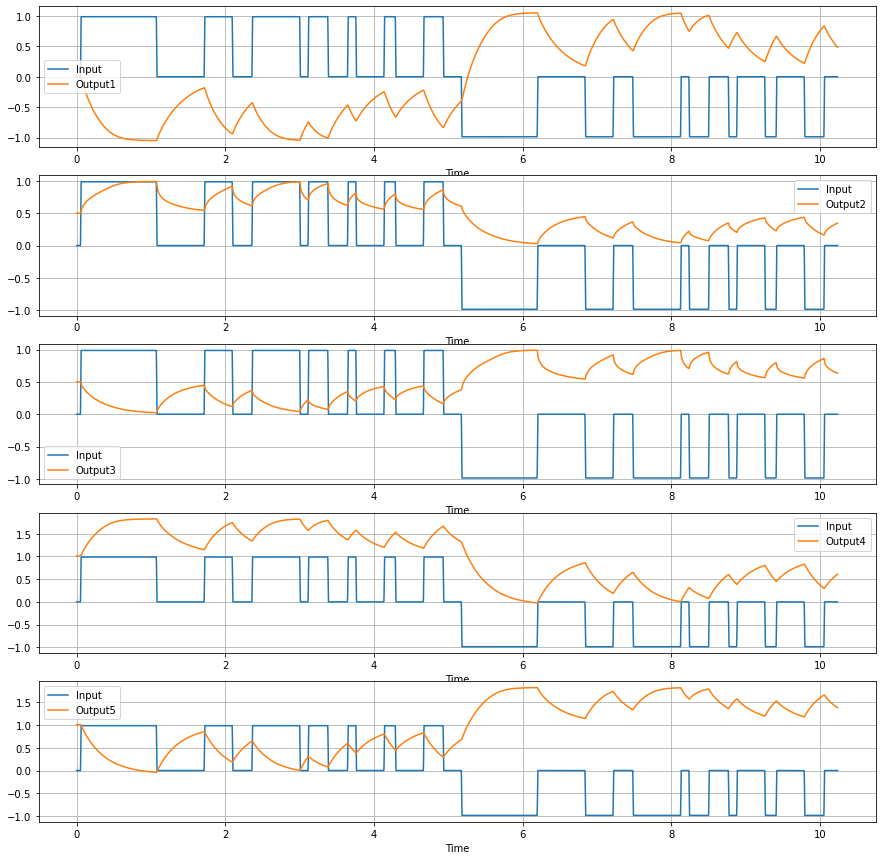

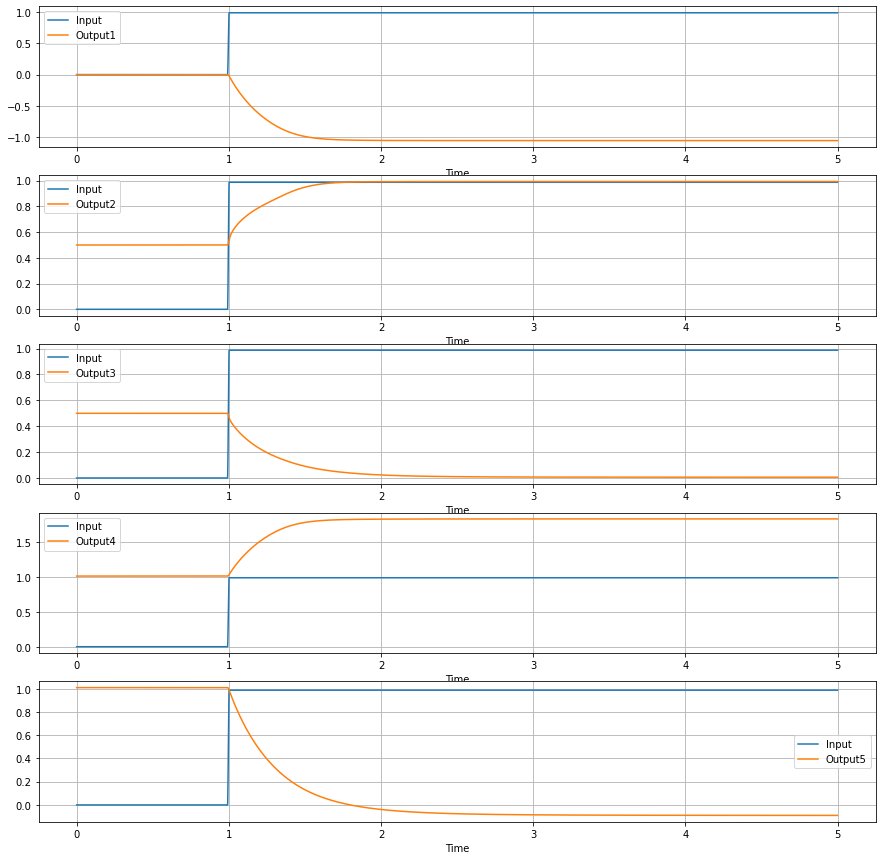

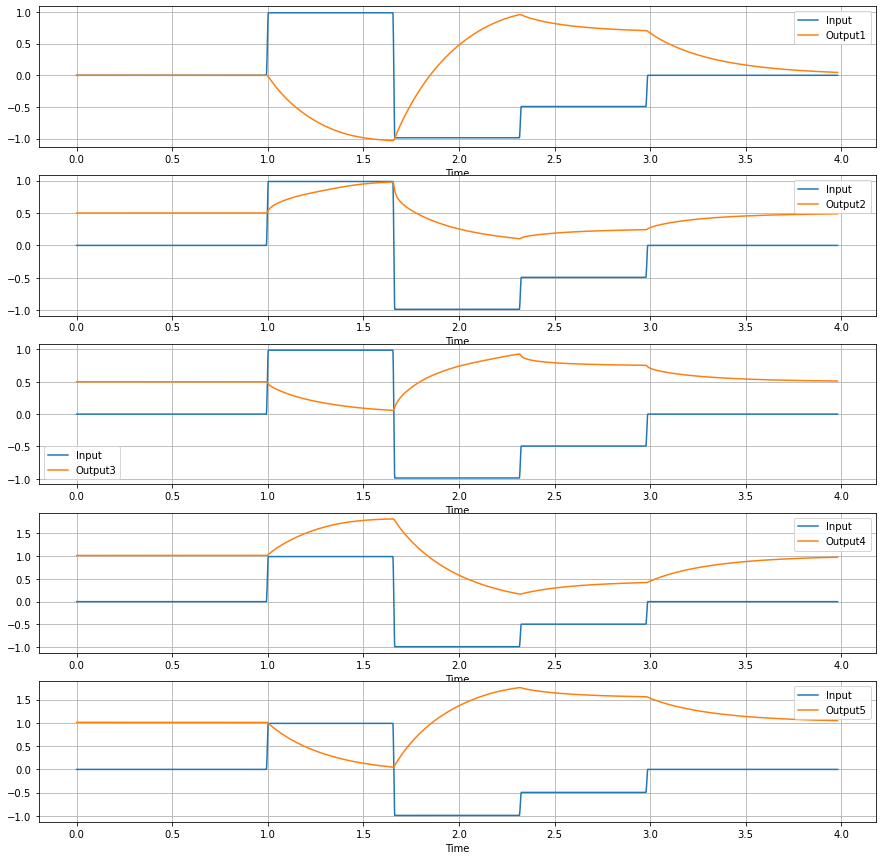

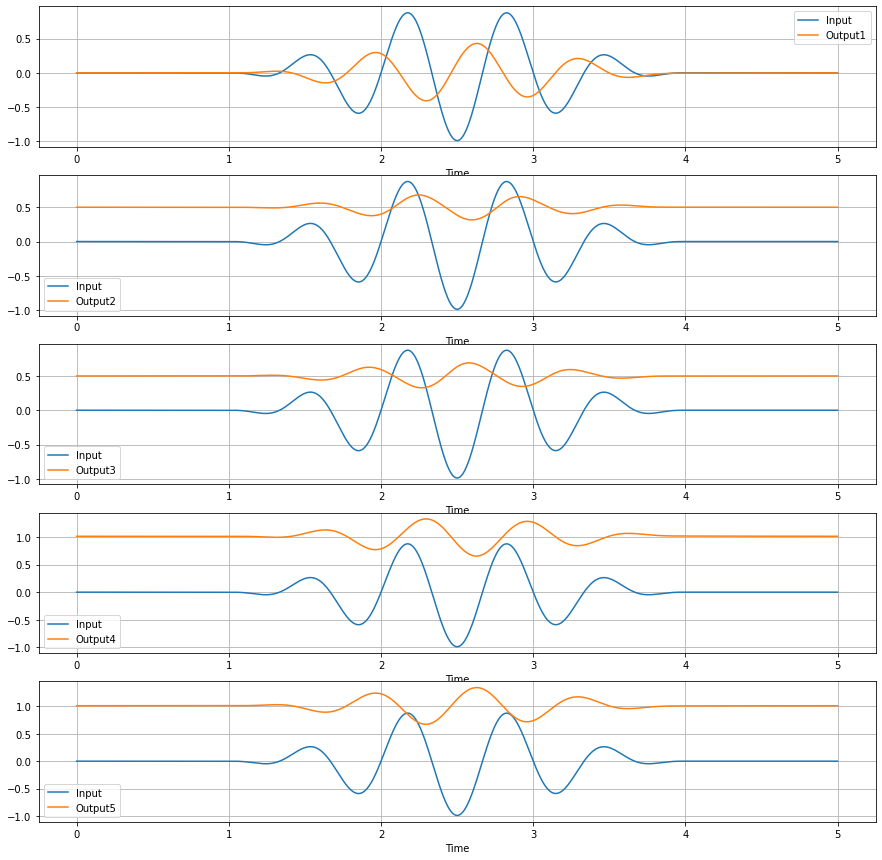

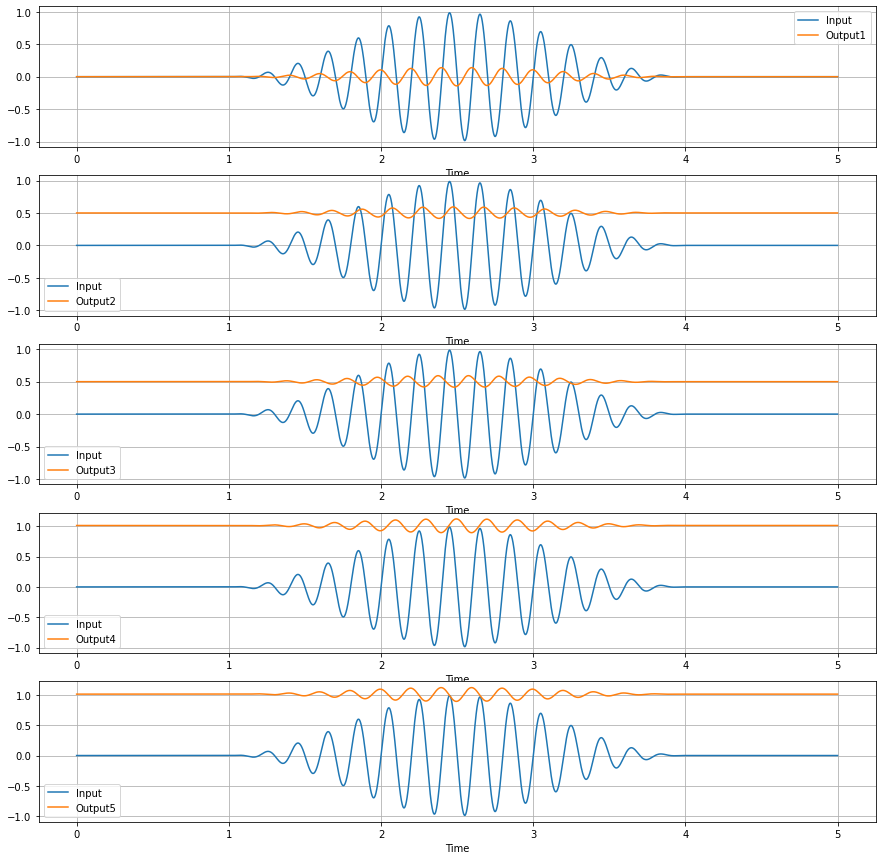

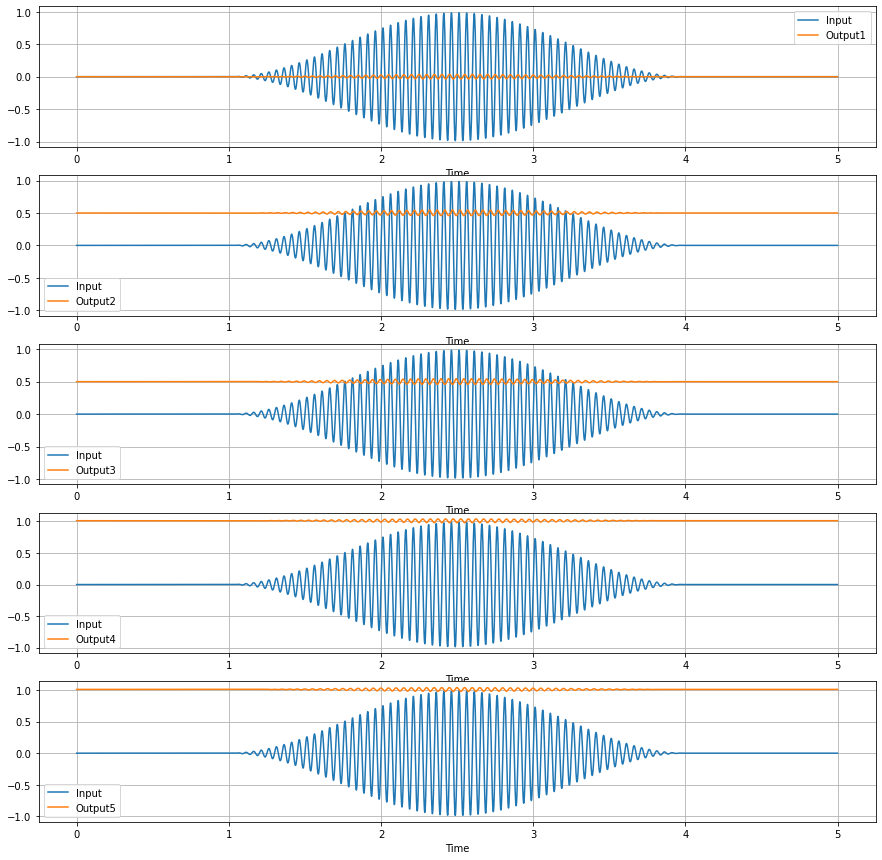

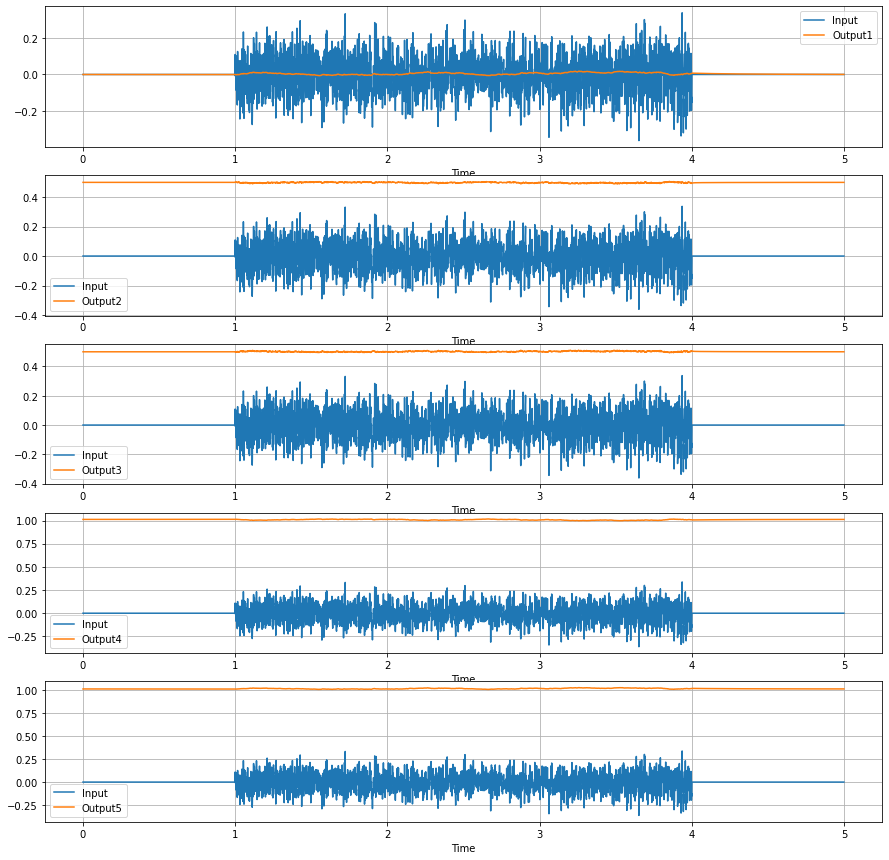

In [63]:
##Tracé des inputs et des outputs

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

Il est nécessaire de standardiser les Outputs pour utiliser les modules scipy LTI, on supprime l'offset et on normalise à 1 les Output

In [4]:
##Calcul des shrink (positif ou négatif) et des offset de chaque output

Output_names = ['Output1','Output2','Output3','Output4','Output5']
Output_correction = {'Output1':[0,0],'Output2':[0,0],'Output3':[0,0],'Output4':[0,0],'Output5':[0,0]}
for name in Output_names:
    offset = d['input0'][name][1]
    Output_correction[name][0] = offset
    
    shrink = (d['input1'][name][5000]-offset)/d['input1']['Input'][5000]
    Output_correction[name][1] = shrink

In [5]:
###Traitement des output
   
d_corrige = copy.deepcopy(d)
    
for key in d_corrige.keys():
    for name in Output_names:
        d_corrige[key][name] = d[key][name] - Output_correction[name][0] 
        d_corrige[key][name] = 1/Output_correction[name][1]*d_corrige[key][name]

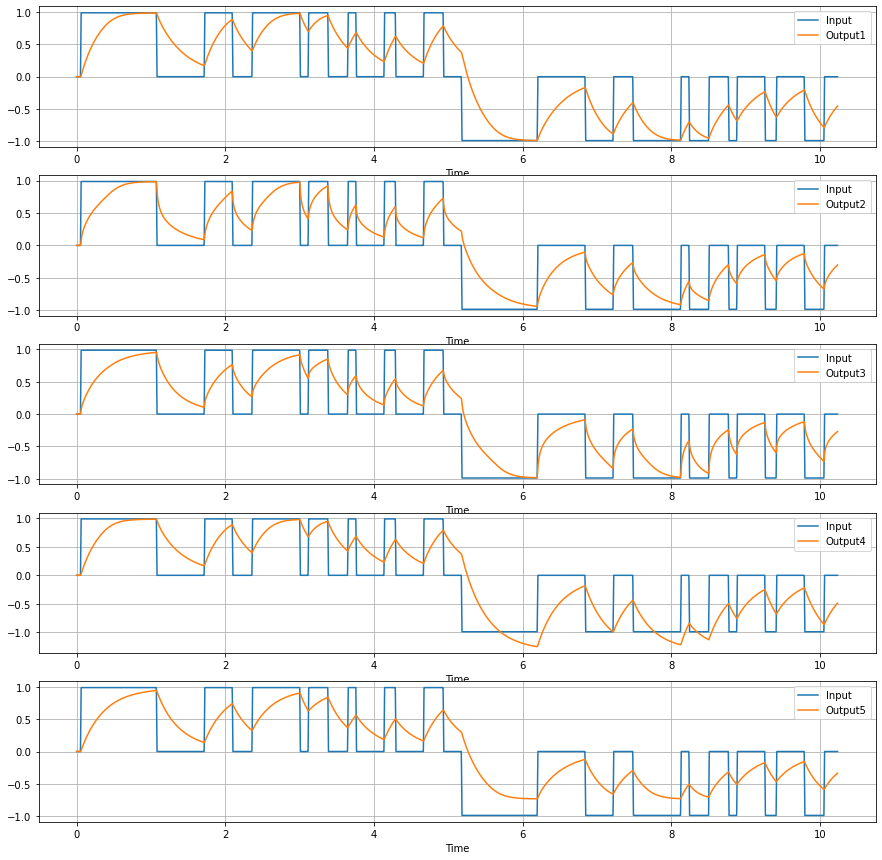

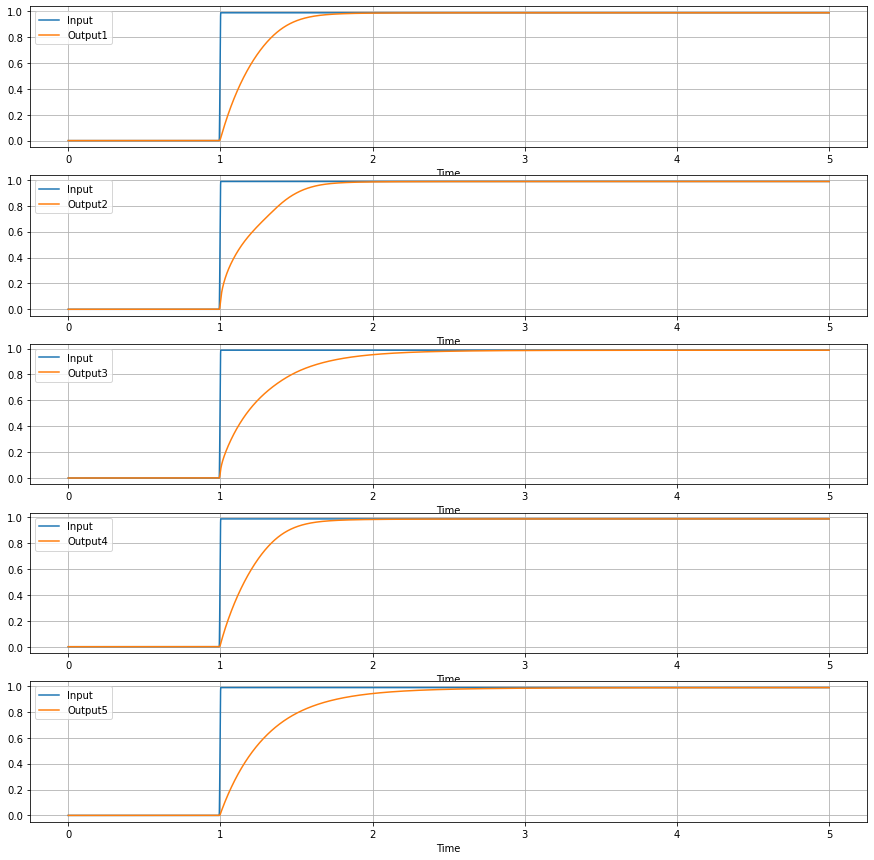

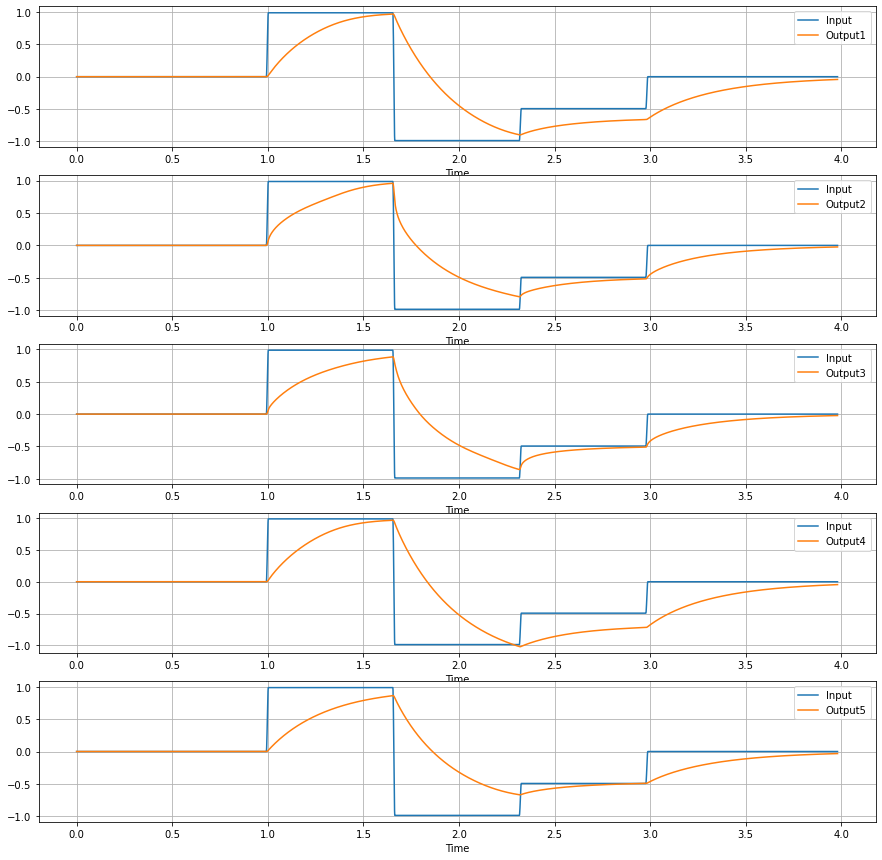

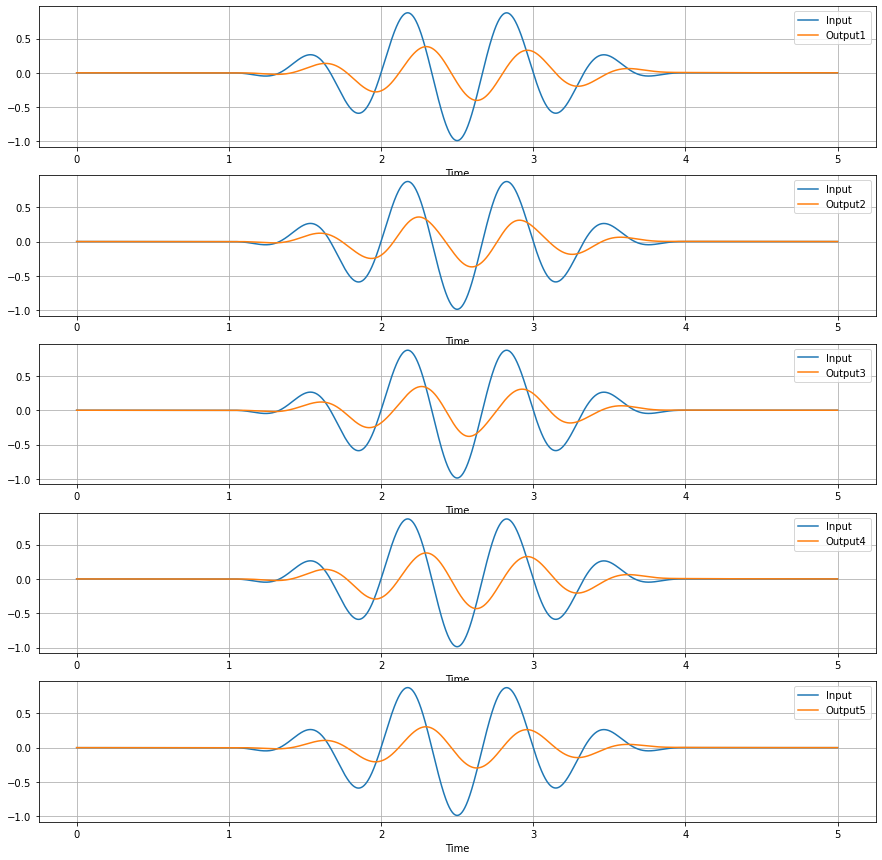

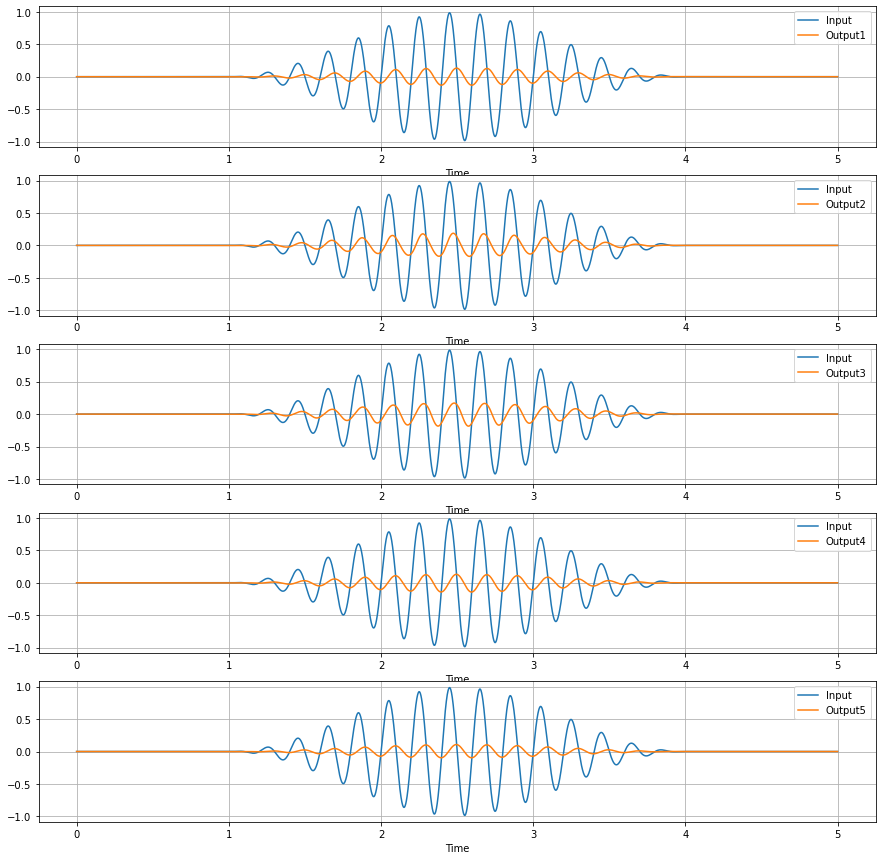

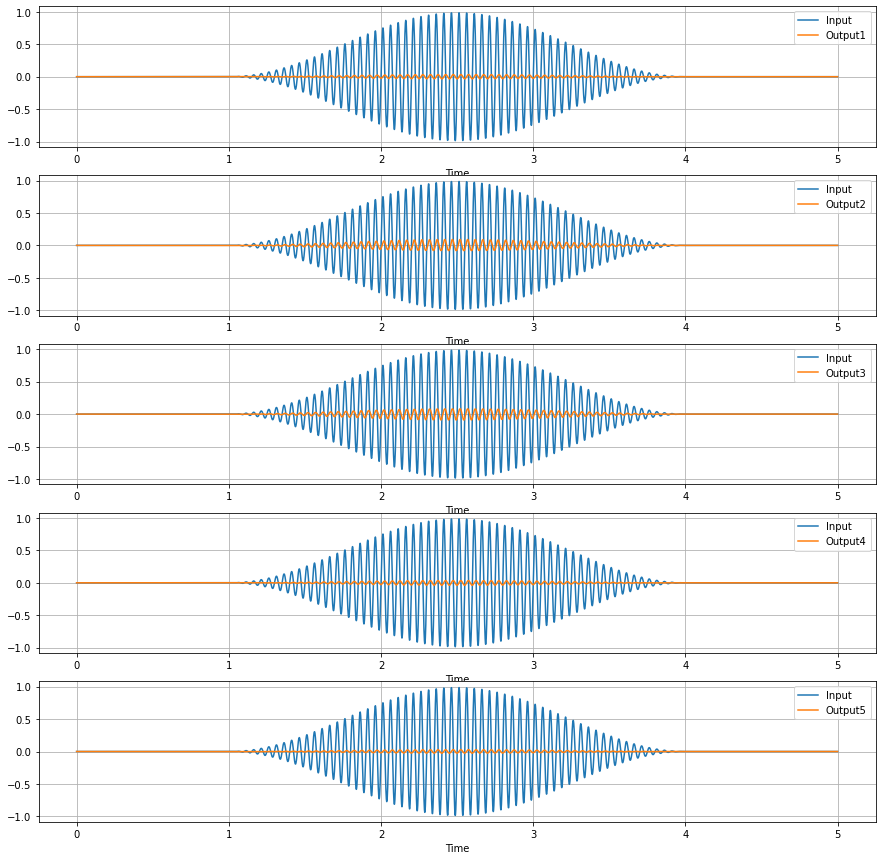

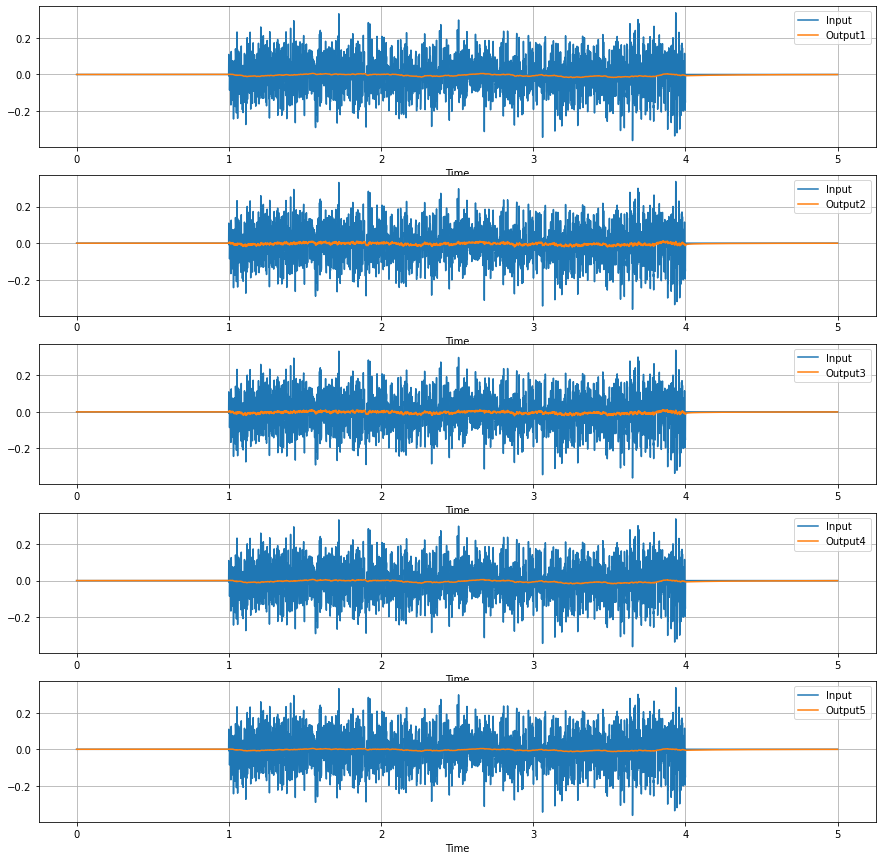

In [124]:
##Tracé des inputs et des Outputs corrigés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        d_corrige[name].plot(ax=ax[k],x='Time',y=[1,k+2],grid='on')

# Stratégie 1 : Calcul des coefficients en minimisant l'erreur d'un seul input

Pour cette stratégie, l'entrainement sur l'input0 est bien plus efficace que les autres. Par ailleurs elle est plus rapide, on peut tester avec des degrés plus élevés pour la fonction de transfert.

In [ ]:
##Calcul des coefficient avec un seul input

input_train = "input0"
params_output = {}
Compteur = 0
N_total = len(Output_names)
degre = 5

for name in Output_names:
    
    Time = d[input_train]['Time']
    Input = d[input_train]['Input']
    Output = d_corrige[input_train][name]
    
    ##Calcul des paramètre à un degré donné
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err, x0, bounds=(-3, 3), args=(Time,Input, Output), verbose=0, ftol=1e-15, gtol=1e-15, xtol = 1e-15)
    x = res.x
    
    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) + "%")

    params_output[name] = x

Avancement : 20%
Avancement : 40%


In [25]:
##Calcul des sorties, en "inversant" la correction effectuée plus tôt

Sorties = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties[key][name+"_approx"] = sortie
    
    Sorties[key] = pd.DataFrame(Sorties[key])

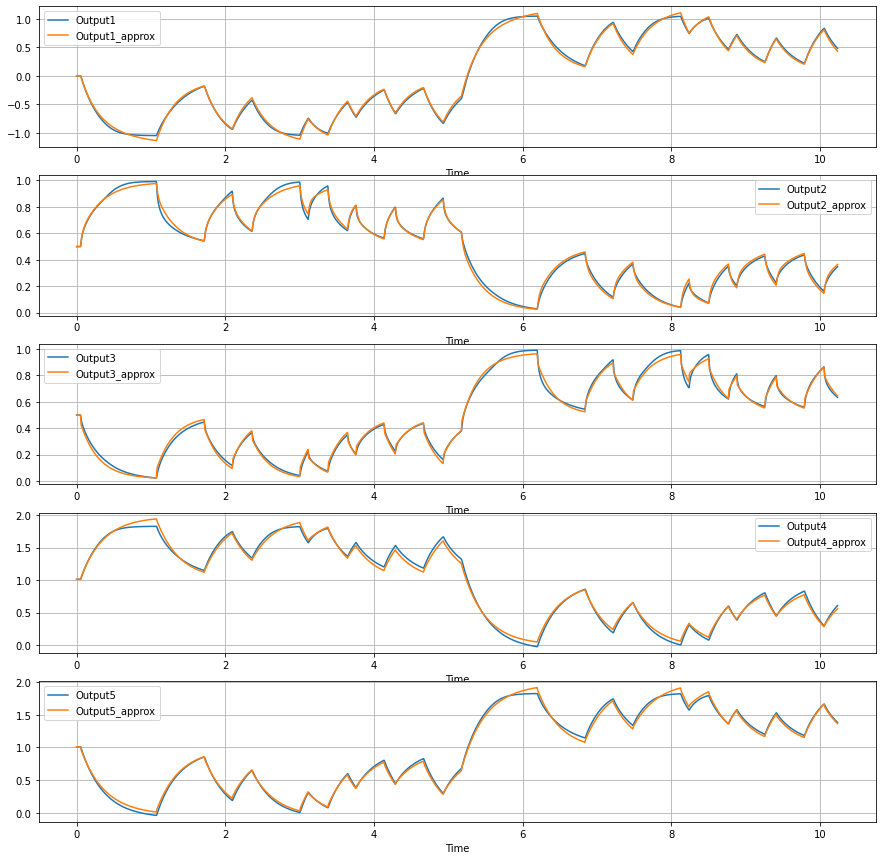

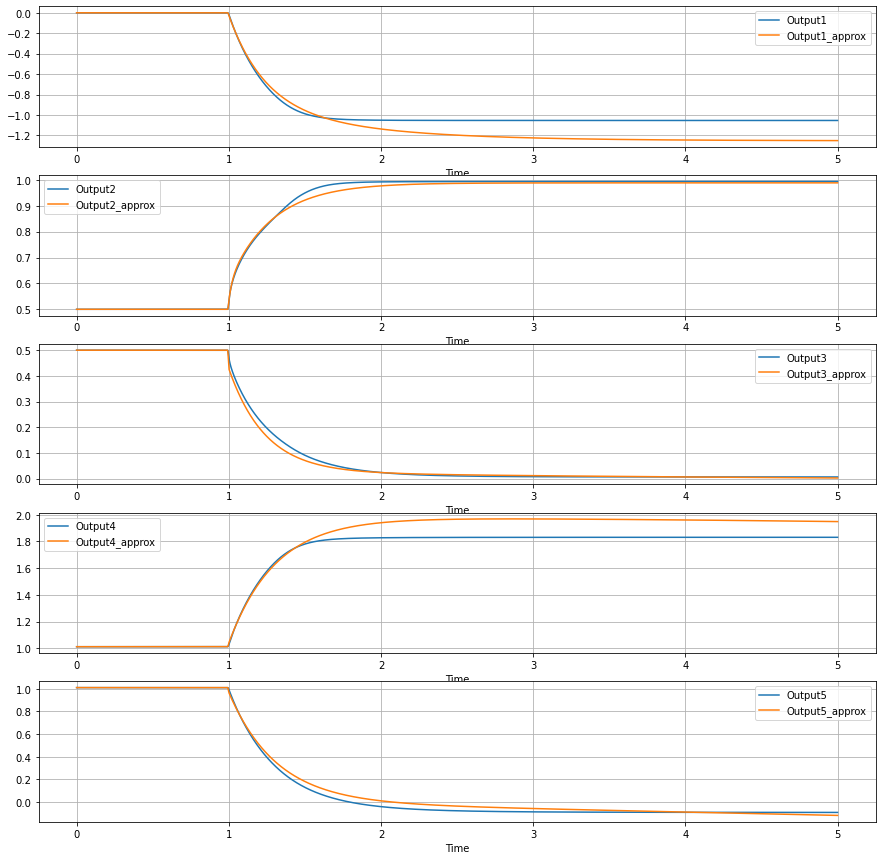

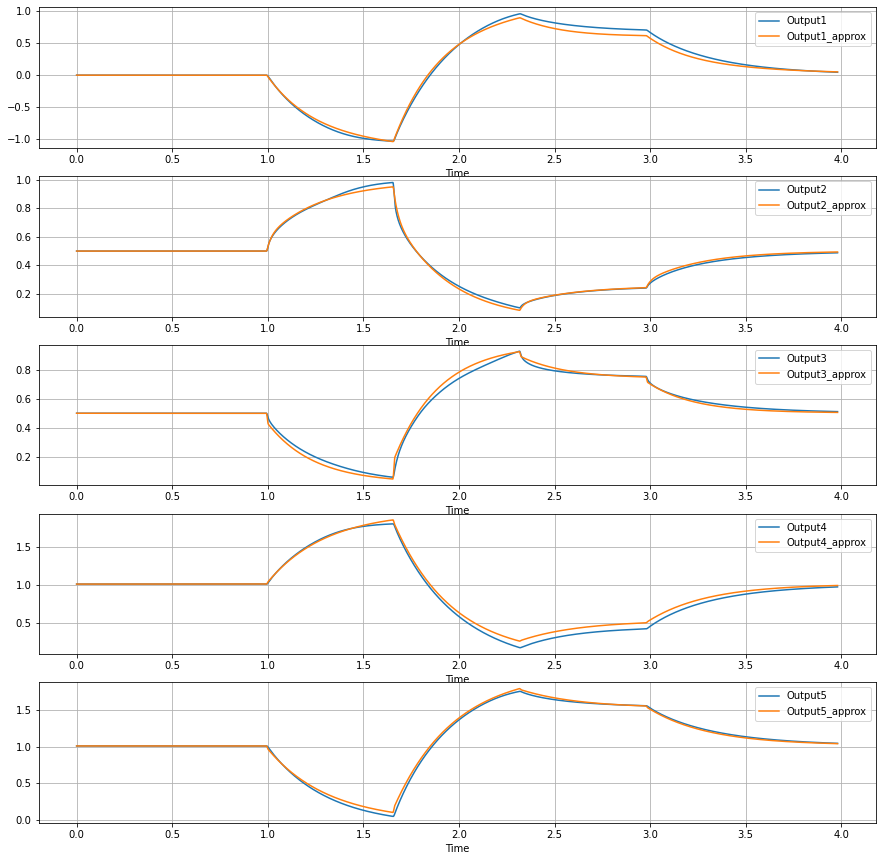

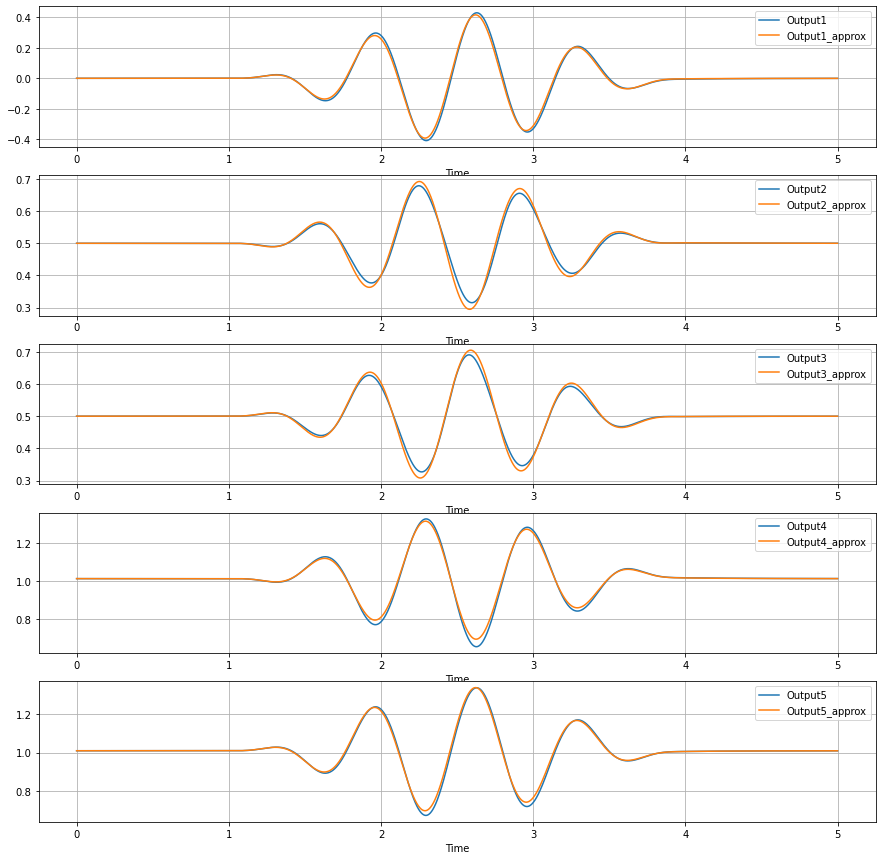

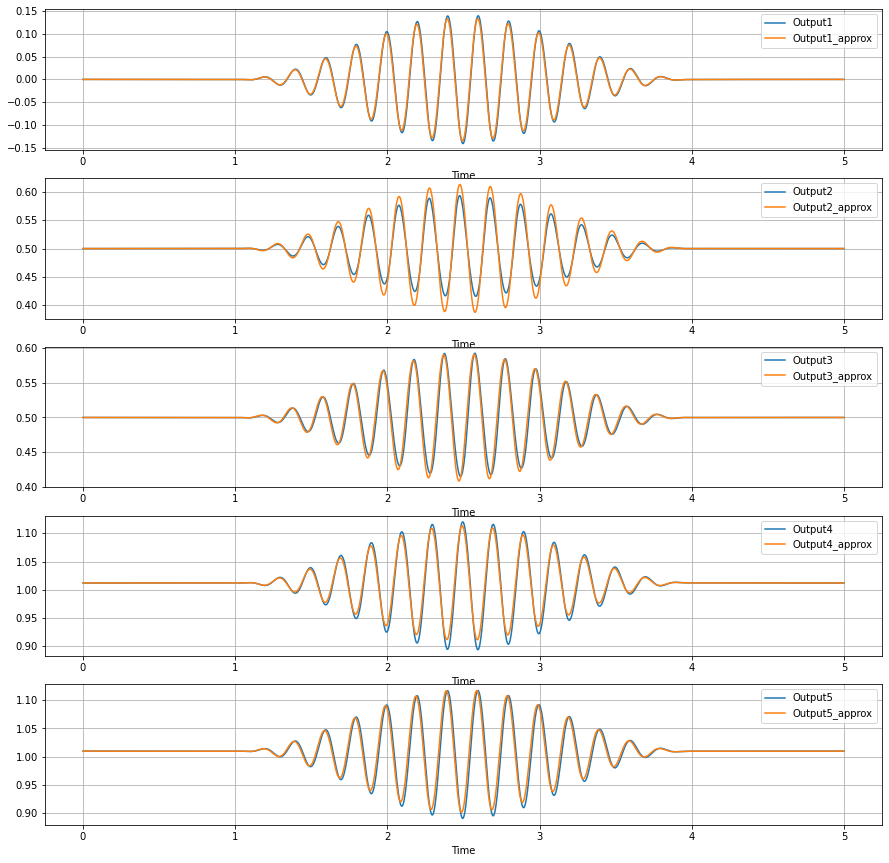

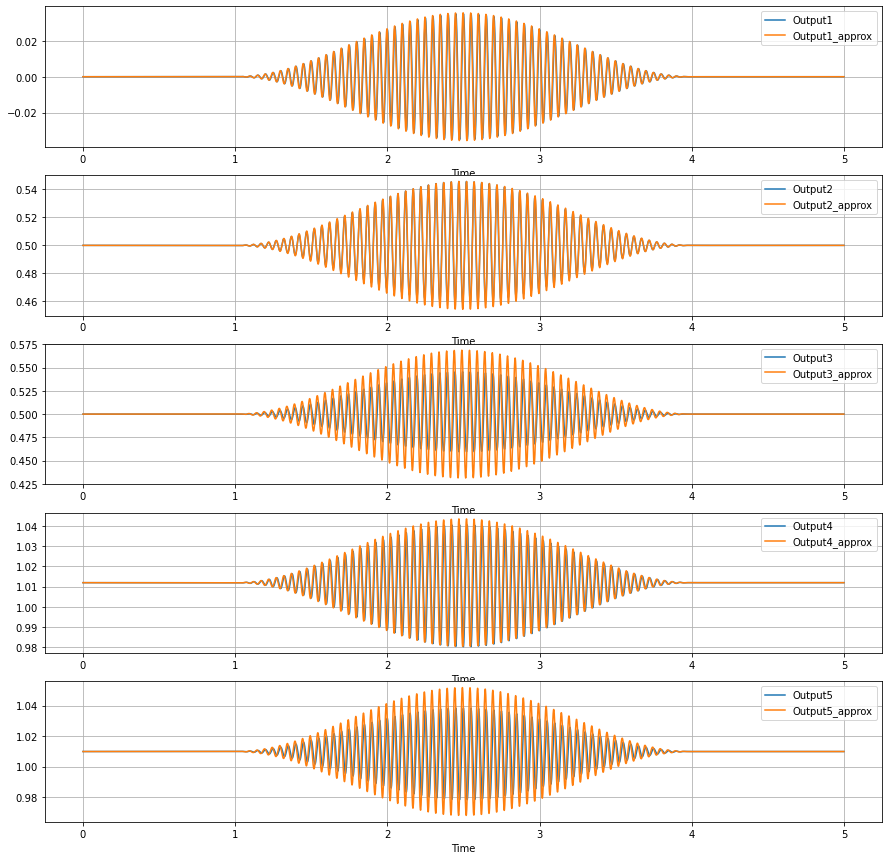

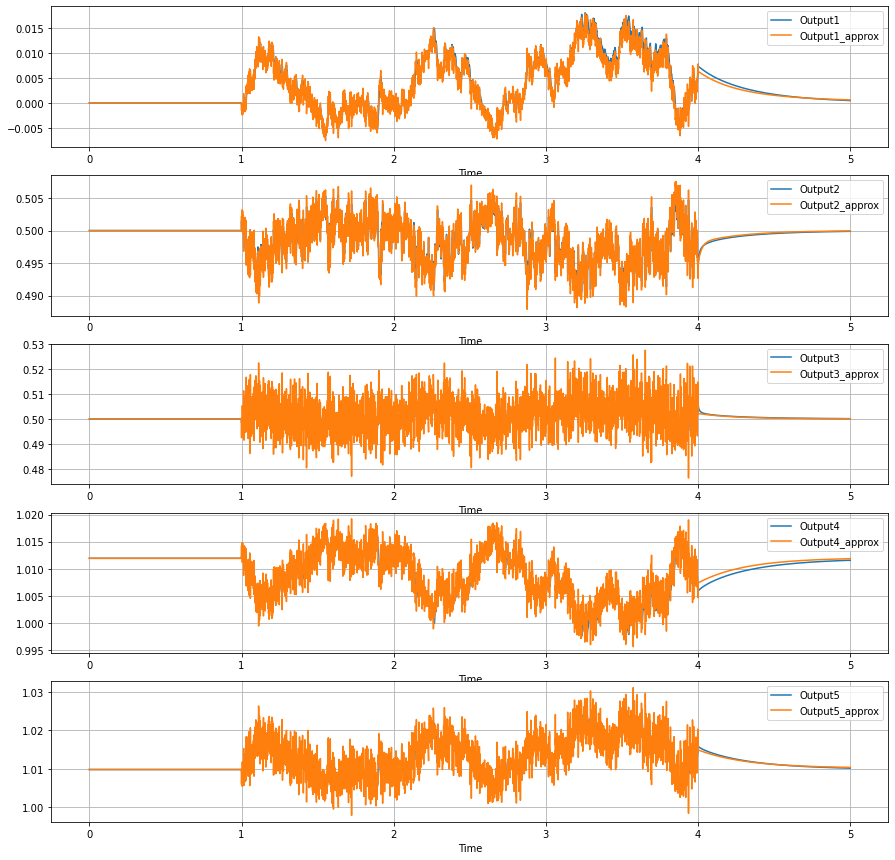

In [26]:
##Tracé des outputs et des outputs approximés

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in names:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [30]:
###RMSE pour chacun des signaux

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties[name][Output_names[k]],Sorties[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name in inputs_train)/(5*len(inputs_train))
        mean_rmse_test += rmse*(name in inputs_test)/(5*len(inputs_test))
        mean_rmse += rmse/(5*len(names))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name == input_train))
        print("-----------------")
        
print("RMSE moyenne sur echantillon train : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

RMSE pour input0 et Output1 : 0.0009893861445647225
Input d'entrainement : True
-----------------
RMSE pour input0 et Output2 : 0.00037096051968746254
Input d'entrainement : True
-----------------
RMSE pour input0 et Output3 : 0.00039547037432842484
Input d'entrainement : True
-----------------
RMSE pour input0 et Output4 : 0.0018744070907287672
Input d'entrainement : True
-----------------
RMSE pour input0 et Output5 : 0.001255712902300007
Input d'entrainement : True
-----------------
RMSE pour input1 et Output1 : 0.018601410373724894
Input d'entrainement : False
-----------------
RMSE pour input1 et Output2 : 0.00010507495533215317
Input d'entrainement : False
-----------------
RMSE pour input1 et Output3 : 0.0001014092922553577
Input d'entrainement : False
-----------------
RMSE pour input1 et Output4 : 0.010819915341546594
Input d'entrainement : False
-----------------
RMSE pour input1 et Output5 : 0.000851215109635589
Input d'entrainement : False
-----------------
RMSE pour input2

# Stratégie 2 : Calcul des coefficients en minimisant l'erreur moyenne des inputs d'entrainement

Entrainement plus couteux en temps mais de meilleurs résultats à degré égal avec la stratégie 1.

In [8]:
inputs_train = ['input0','input1','input3','input5']
inputs_test = ['input2','input4','input6']

entrees_train = [d[key]['Input'] for key in inputs_train]
times_train = [d[key]['Time'] for key in inputs_train]
params_output_2 = {}
degre = 3
N_total = len(Output_names)
Compteur = 0

for name in Output_names:
    outputs = [d_corrige[key][name] for key in inputs_train]
    
    x0 = np.ones(2*degre)
    x = np.arange(1,2*degre+1)

    res = least_squares(err_multi, x0, bounds=(-3, 3), args=(times_train,entrees_train,outputs), verbose=1, ftol=1e-15, gtol=1e-15, xtol = 1e-15, max_nfev = 50)
    x = res.x

    Compteur += 1
    print("Avancement : " + str(round(Compteur/N_total*100)) +"%")
        
    params_output_2[name] = x

The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 9.2728e-02, final cost 3.2001e-05, first-order optimality 4.15e-04.
Avancement : 20%
The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 5.4707e-02, final cost 7.0185e-06, first-order optimality 4.25e-04.
Avancement : 40%
The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 5.6559e-02, final cost 3.1172e-06, first-order optimality 1.28e-04.
Avancement : 60%
The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 9.8025e-02, final cost 1.4608e-04, first-order optimality 2.03e-03.
Avancement : 80%
The maximum number of function evaluations is exceeded.
Function evaluations 50, initial cost 9.4765e-02, final cost 3.6668e-06, first-order optimality 1.10e-04.
Avancement : 100%


In [9]:
##Calcul des sorties, en "inversant" la correction effectuée plus tôt

Sorties_v2 = copy.deepcopy(d)

for key in d.keys():
    for name in Output_names:
        Time = d[key]['Time']
        Input = d[key]['Input']
        Output = d[key][name]
        
        x = params_output_2[name]
        sortie = pred(x,Time,Input)*Output_correction[name][1]+Output_correction[name][0]  ##On inverse la correction faite sur les outputs
        Sorties_v2[key][name+"_approx"] = sortie
    
    Sorties_v2[key] = pd.DataFrame(Sorties_v2[key])

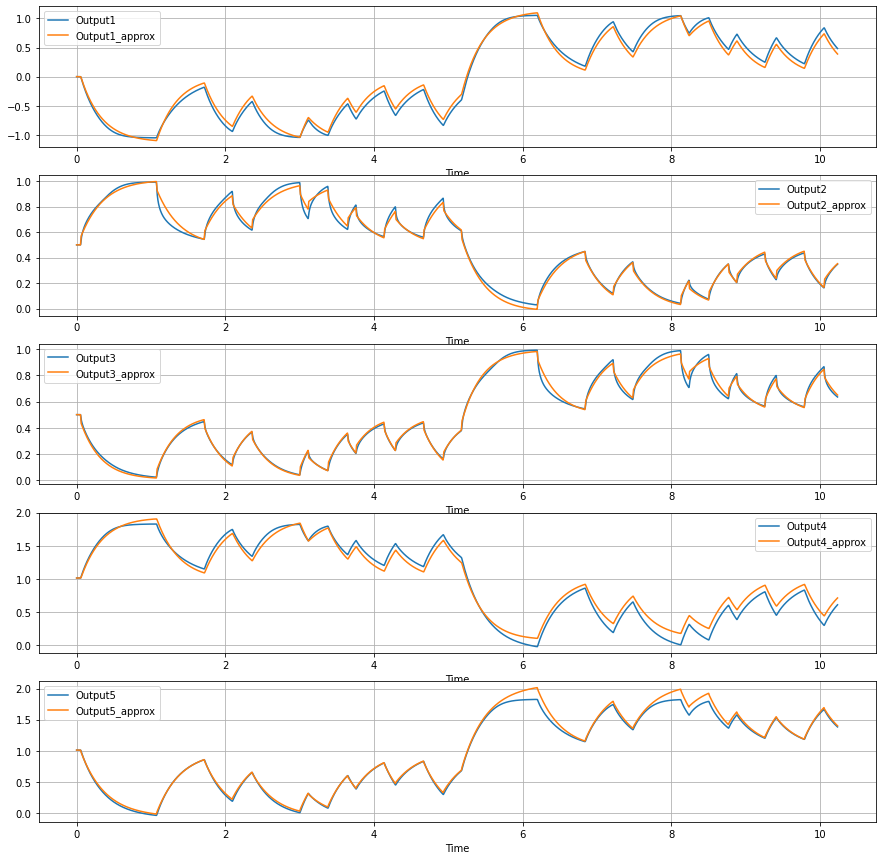

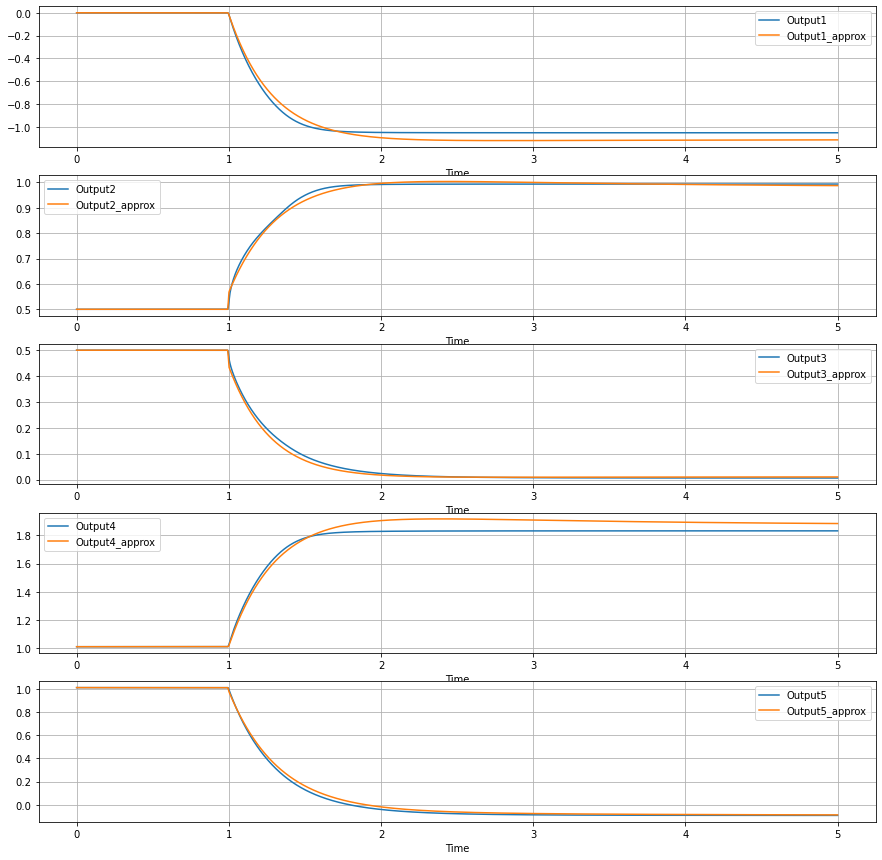

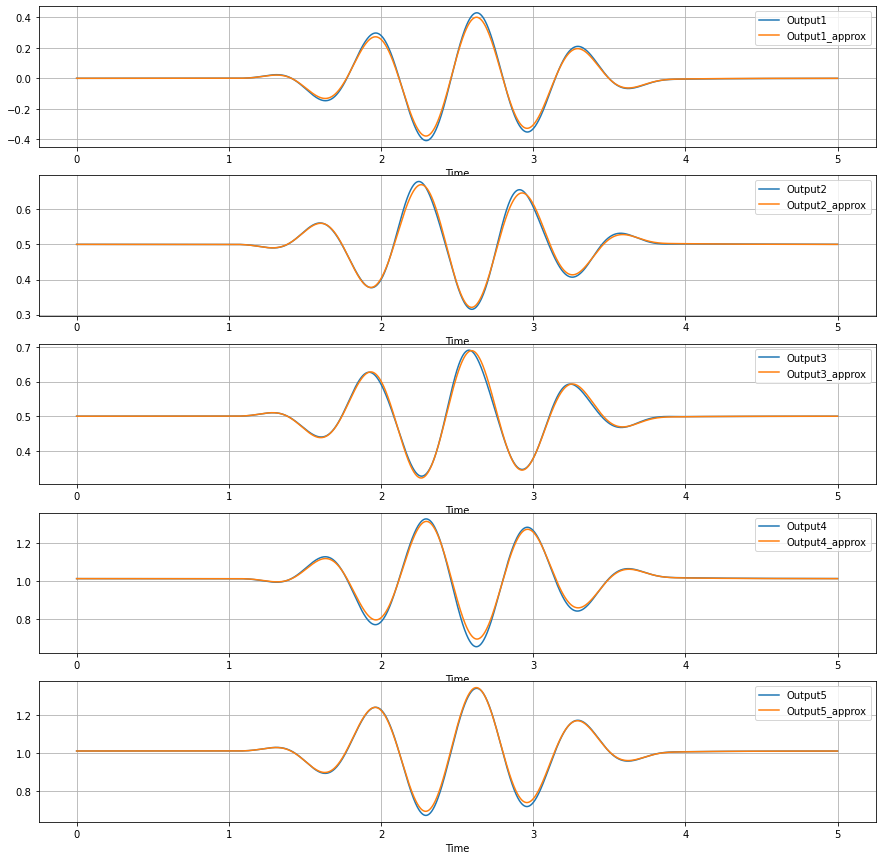

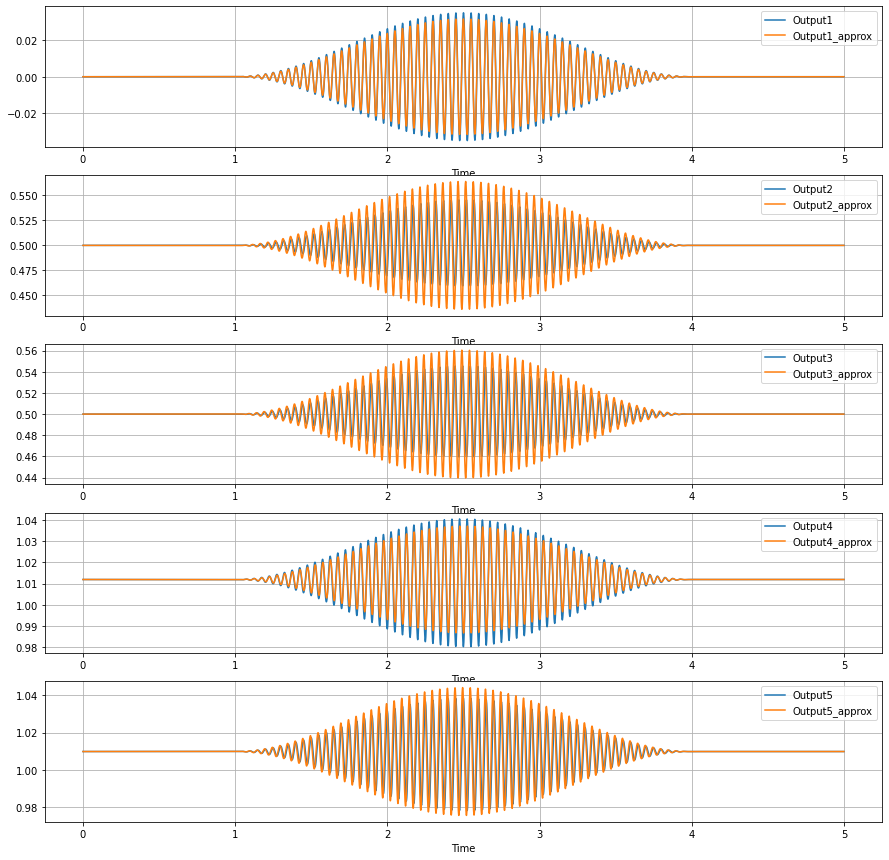

In [10]:
##Tracé des outputs et des outputs approximés sur l'échantillon d'entrainement

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_train:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

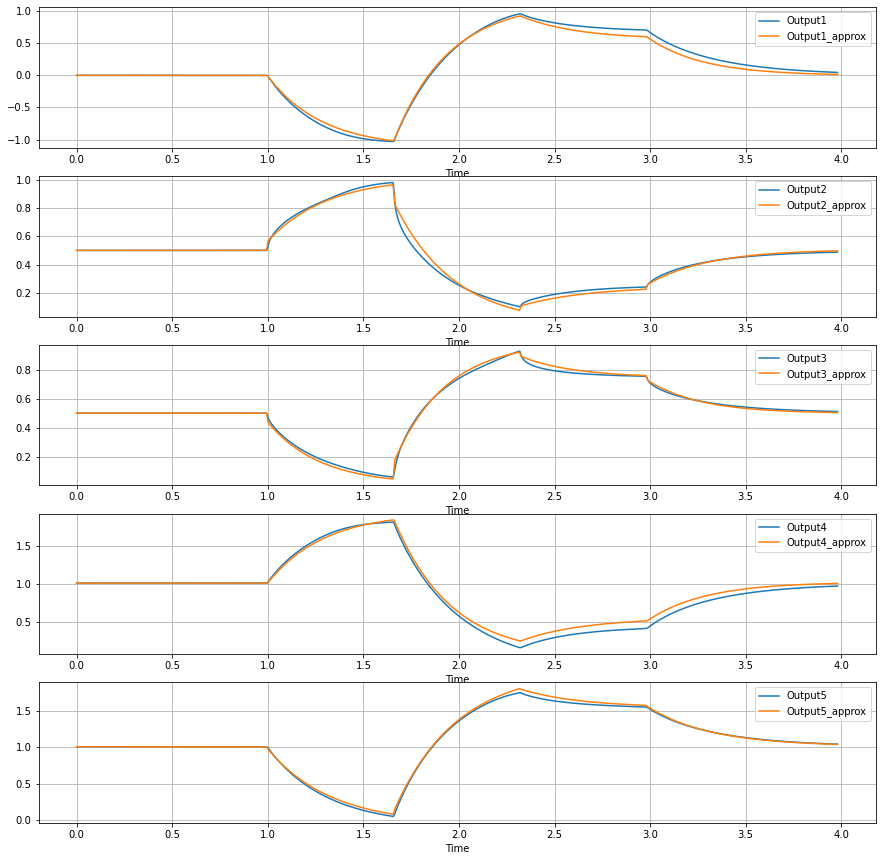

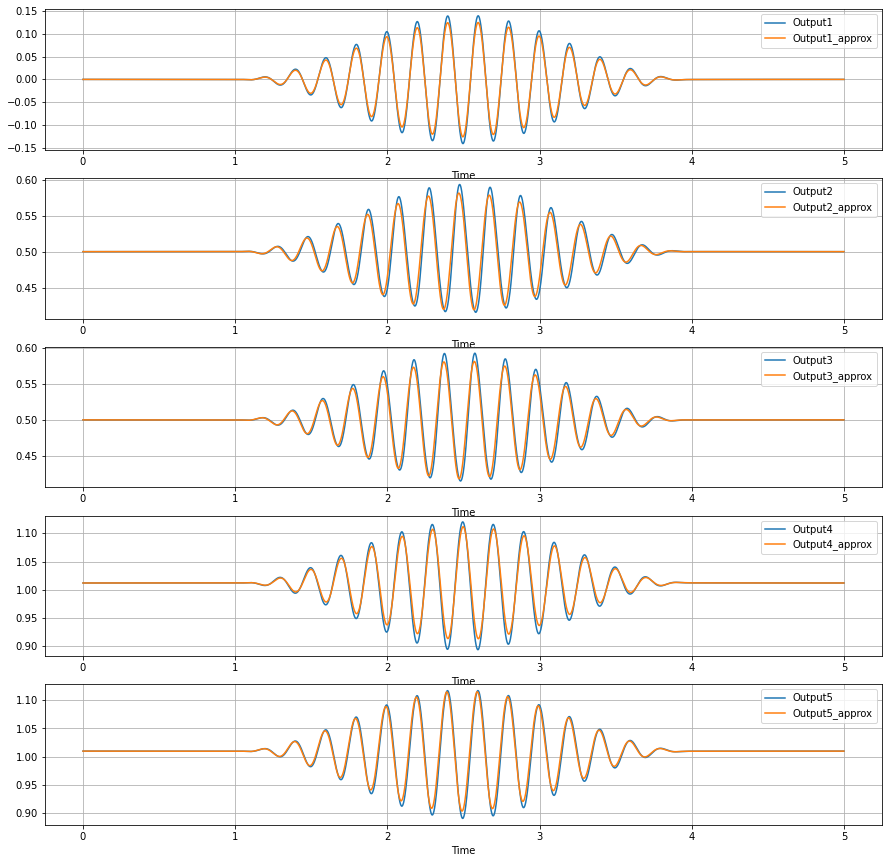

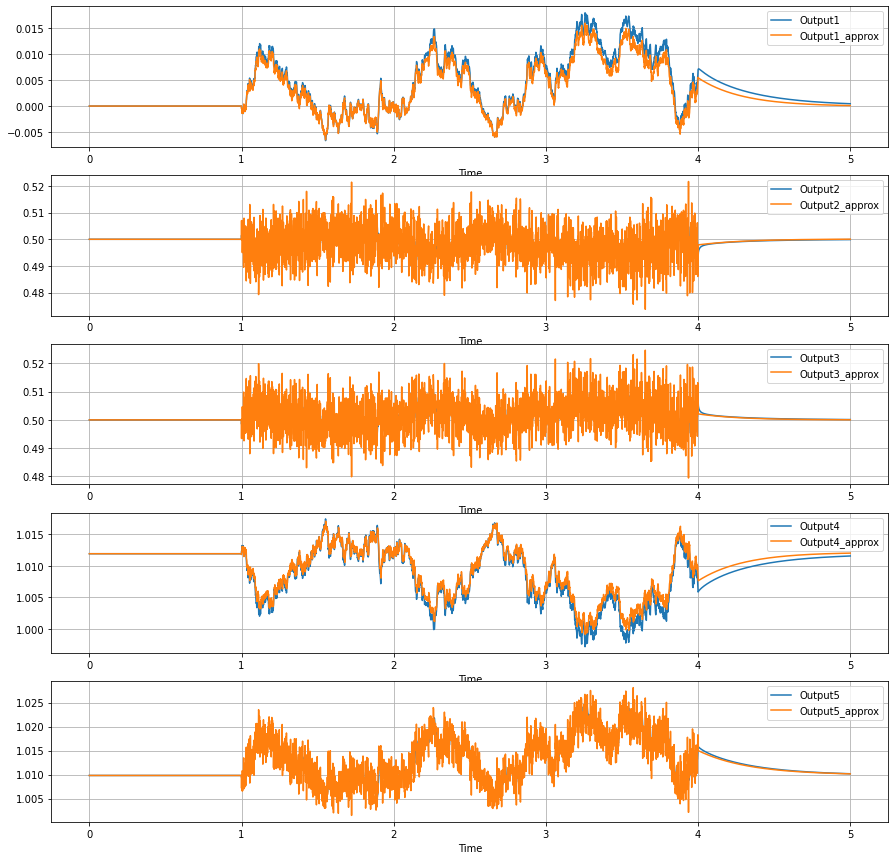

In [11]:
##Tracé des outputs et des outputs approximés sur l'échantillon de test

N_input   = 1
N_outputs = 5
N_signals = len(names)

for name in inputs_test:
    fig,ax = plt.subplots(N_outputs,1,figsize=(15,15))
    for k in range(N_outputs):
        Sorties_v2[name].plot(ax=ax[k],x='Time',y=[k+2,k+2+N_outputs],grid='on')

In [31]:
###RMSE pour chacun des signaux

N_input   = 1
N_outputs = 5
N_signals = len(names)
mean_rmse_test = 0
mean_rmse_train = 0 
mean_rmse = 0

for name in names:
    for k in range(N_outputs):
        rmse = RMSE(Sorties_v2[name][Output_names[k]],Sorties_v2[name][Output_names[k]+"_approx"])
        mean_rmse_train += rmse*(name in inputs_train)/(5*len(inputs_train))
        mean_rmse_test += rmse*(name in inputs_test)/(5*len(inputs_test))
        mean_rmse += rmse/(5*len(names))
        print("RMSE pour " + str(name) +" et " + Output_names[k] + " : " + str(rmse))
        print("Input d'entrainement : " + str(name in inputs_train))
        print("Amelioration : " + str(rmse<RMSE(Sorties[name][Output_names[k]],Sorties[name][Output_names[k]+"_approx"])))
        print("-----------------")

        
print("RMSE moyenne sur echantillon train : " + str(mean_rmse_train) )
print("RMSE moyenne sur echantillon test : " + str(mean_rmse_test) )
print("RMSE moyenne : " + str(mean_rmse) )

RMSE pour input0 et Output1 : 0.006110356406173681
Input d'entrainement : True
Amelioration : False
-----------------
RMSE pour input0 et Output2 : 0.0006773347316640598
Input d'entrainement : True
Amelioration : False
-----------------
RMSE pour input0 et Output3 : 0.0004088498371475824
Input d'entrainement : True
Amelioration : False
-----------------
RMSE pour input0 et Output4 : 0.008424056472111622
Input d'entrainement : True
Amelioration : False
-----------------
RMSE pour input0 et Output5 : 0.0030611524511535756
Input d'entrainement : True
Amelioration : False
-----------------
RMSE pour input1 et Output1 : 0.002859418281971586
Input d'entrainement : True
Amelioration : True
-----------------
RMSE pour input1 et Output2 : 5.901116627159752e-05
Input d'entrainement : True
Amelioration : True
-----------------
RMSE pour input1 et Output3 : 5.19831265544979e-05
Input d'entrainement : True
Amelioration : True
-----------------
RMSE pour input1 et Output4 : 0.003212679181461236
Inpu

# Stratégie 3 : Agrégation des coefficients selon la similitude entre des inputs